## SSD Demo

In [1]:
!ln -s /datasets/ee285f-public/nntools.py .

ln: failed to create symbolic link './nntools.py': File exists


In [2]:
%matplotlib inline
import os
import os.path as osp
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import math

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import cv2
import ssd
from ssd import build_ssd
import random
from matplotlib import pyplot as plt
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform

In [3]:
if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
VOC_ROOT='//datasets/ee285f-public/PascalVOC2012/'

In [6]:
testset = VOCDetection(VOC_ROOT, [('2012', 'val')], None, VOCAnnotationTransform())

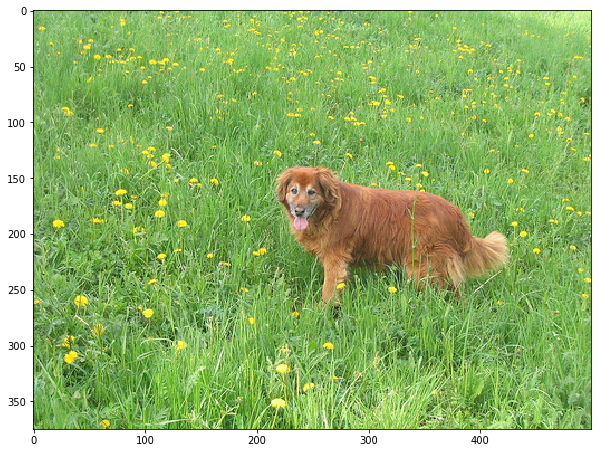

In [21]:
img_id = random.randint(0,len(testset))
image = testset.pull_image(img_id)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


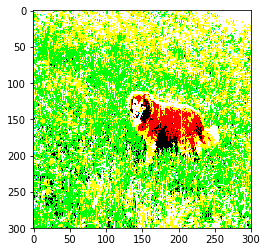

In [23]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

In [25]:
x.shape

torch.Size([3, 300, 300])

In [27]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('ssd300_mAP_77.43_v2.pth')

Loading weights into state dict...
Finished!


In [28]:
img = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    img = img.cuda()
y = net(img)

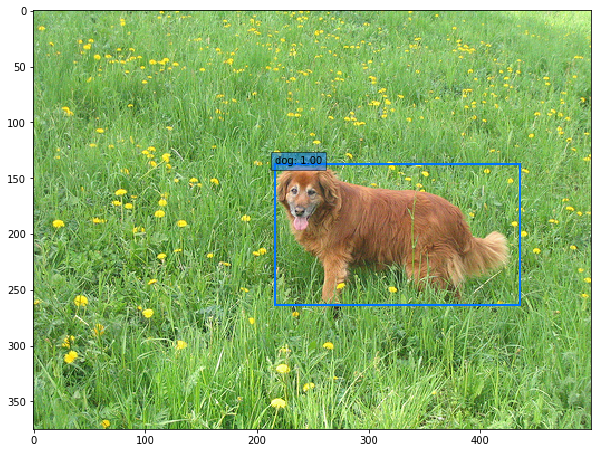

In [29]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

In [583]:
impath = '//datasets/ee285f-public/PascalVOC2012/JPEGImages/2012_000004.jpg'

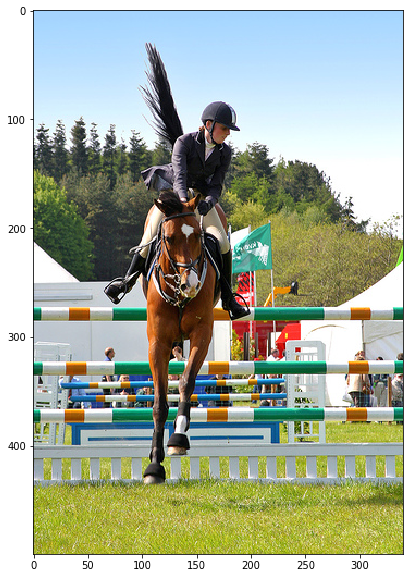

In [584]:
new = cv2.imread(impath, cv2.IMREAD_COLOR)
rgb_image = cv2.cvtColor(new, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

In [585]:
new.shape

(500, 340, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


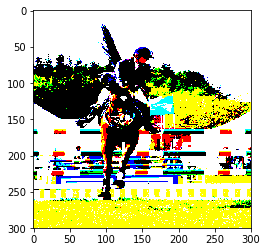

In [586]:
x = cv2.resize(new, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

In [587]:
img = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    img = img.cuda()
y = net(img)

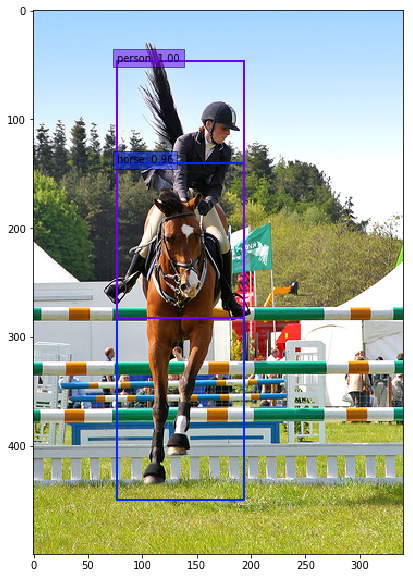

In [588]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

In [589]:
img = new
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = img[...,::-1]/255.0
noise =  np.random.normal(loc=0, scale=1, size=img.shape)
noise2 = (noise - noise.min())/(noise.max()-noise.min())

# noise overlaid over image
noisy = np.clip((img + noise*0.2),0,1)
noisy2 = np.clip((img + noise*0.4),0,1)

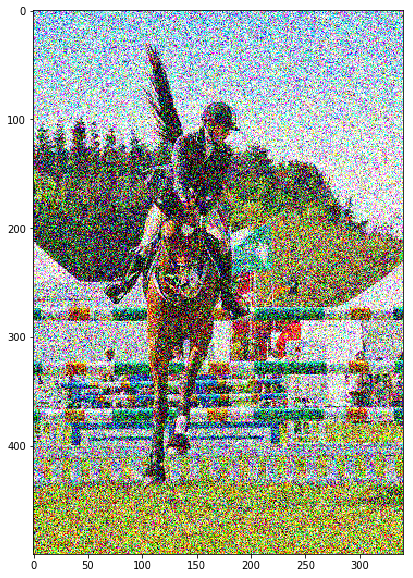

In [591]:
plt.figure(figsize=(10,10))
plt.imshow(noisy2)

In [592]:
noisy = noisy2*255.0
print(noisy.shape)

(500, 340, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


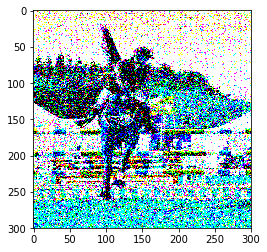

In [593]:
x = cv2.resize(noisy, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

In [594]:
img = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    img = img.cuda()
y = net(img)

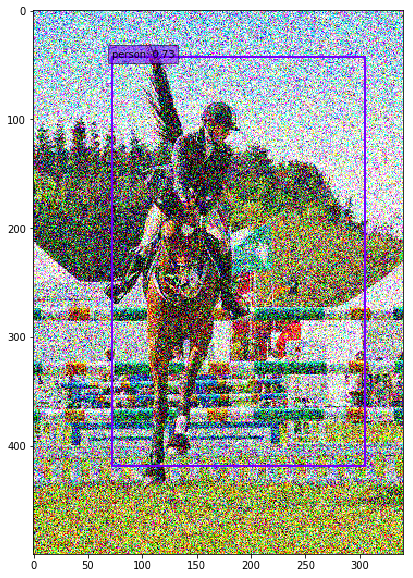

In [595]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(noisy/255)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

In [596]:
net_DUDnCNN = torch.load('../Assignment_4_FINAL/denNet.pt')

In [597]:
noisy.shape

(500, 340, 3)

In [598]:
class NNRegressor(nt.NeuralNetwork):
    
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()
        
    def criterion(self, y, d):
        return self.mse(y, d)

In [599]:
class DenoisingStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
        psnr = 10 * math.log10((4 * torch.numel(y)) / ((torch.dist(y,d,2)) ** 2))
        self.running_psnr += psnr

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr/self.number_update
        return {'loss': loss, 'psnr': psnr}

In [600]:
class DUDnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        
        self.conv.append(nn.Conv2d(3, C, 3, padding=1)) # Padding = (3-1)/2 ==> 1
        
        for k in range(D):
            if (k == D/2):
                l = 1
            elif(k > D/2):
                l += 2
            else:
                l = 0
            
            dil = int(1 + 2**(k-l) -1)
            self.conv.append(nn.Conv2d(C, C, 3, padding=dil, dilation=dil))
        
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
    
        for k in range(len(self.conv)-1):
            self.conv[k].weight.data = nn.init.kaiming_normal_(self.conv[k].weight.data, nonlinearity='relu')
        
        for k in range(D):    
            self.bn[k].weight.data = nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))
        
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for k in range(D):
            torch.backends.cudnn.benchmark=True  # Q20 
            h = self.conv[k+1](h)
            torch.backends.cudnn.benchmark=False  # Q20
            h = F.relu(self.bn[k](h))
        
        y = self.conv[D+1](h) + x
        return y

In [601]:
noisy.shape

(500, 340, 3)

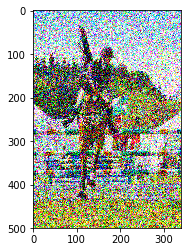

In [602]:
plt.imshow(noisy/255)

In [603]:
noisy_final = noisy

In [604]:
im = Image.fromarray(np.uint8(noisy_final))

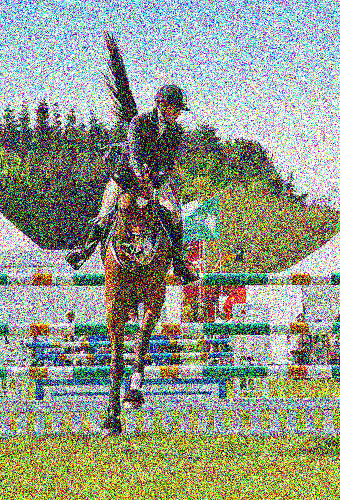

In [605]:
im

In [606]:
image_size = (300,300)
# declare a tranform to convert the image to a tensor and normalize it between [-1, 1]
transform = tv.transforms.Compose([tv.transforms.Resize(image_size),
                            tv.transforms.ToTensor(), tv.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]) 
noisy = transform(im)

In [607]:
noisy = noisy.unsqueeze(0)

In [608]:
noisy.shape

torch.Size([1, 3, 300, 300])

In [609]:
y = (net_DUDnCNN.forward(noisy)).detach()

In [610]:
y.shape

torch.Size([1, 3, 300, 300])

In [611]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

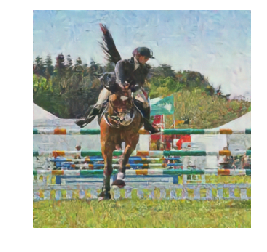

In [612]:
myimshow(y[0])

In [613]:
y[0].shape

torch.Size([3, 300, 300])

In [614]:
new_final = y[0].permute(1,2,0)

In [615]:
#new_final = new_final.reshape(300,300,3)
print(new_final.shape)

torch.Size([300, 300, 3])


In [616]:
new_final = new_final.numpy()

In [617]:
new_final = 255.0*((new_final+1)/2)

In [618]:
new_final.shape

(300, 300, 3)

In [619]:
im2 = Image.fromarray(np.uint8(new_final))

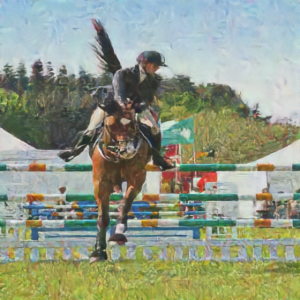

In [620]:
im2

In [621]:
tran = tv.transforms.Compose([tv.transforms.Resize((500,340)), tv.transforms.ToTensor()])
new_final2 = tran(im2)

In [622]:
new_final2 = new_final2*255.0
new_final2 = new_final2.permute(1,2,0)
new_final2 = new_final2.numpy()

In [623]:
new_final2.shape

(500, 340, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


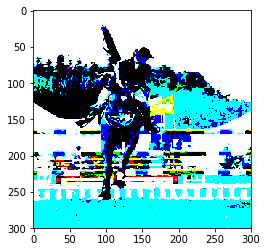

In [624]:
x = cv2.resize(new_final, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

In [625]:
img = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    img = img.cuda()
y = net(img)

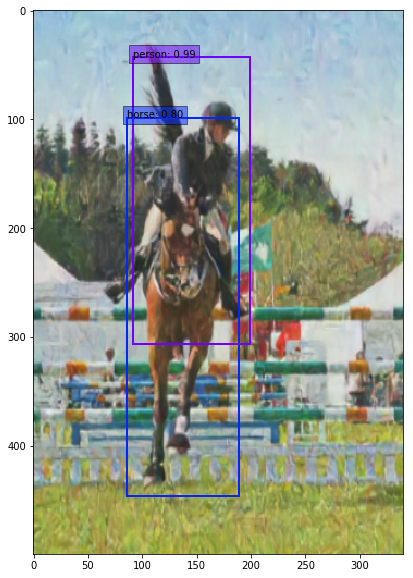

In [626]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(new_final2/255)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1